# 作業 : (Kaggle)鐵達尼生存預測
https://www.kaggle.com/c/titanic

# [作業目標]
- 試著調整特徵篩選的門檻值, 觀察會有什麼影響效果

# [作業重點]
- 調整相關係數過濾法的篩選門檻, 看看篩選結果的影響 (In[5]~In[8], Out[5]~Out[8])
- 調整L1 嵌入法篩選門檻, 看看篩選結果的影響 (In[9]~In[11], Out[9]~Out[11])

In [85]:
import numpy as np

from scipy.stats import pearsonr

np.random.seed(0)
size = 300
x = np.random.normal(0, 1, size)
print("Lower noise", pearsonr(x, x + np.random.normal(0, 1, size)))
print("Higher noise", pearsonr(x, x + np.random.normal(0, 10, size)))

Lower noise (0.7182483686213841, 7.32401731299835e-49)
Higher noise (0.057964292079338155, 0.3170099388532475)


In [86]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
data_path = 'C:/data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId'] , axis=1)
df.head()
##df.info()
##df.describe() 
#df.describe(include=['O']) 
df.describe(include='all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,"Mellinger, Miss. Madeleine Violet",male,NaN,NaN,NaN,1601,NaN,G6,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


          Survived    Pclass       Age     SibSp     Parch      Fare
Survived  1.000000 -0.338481 -0.077221 -0.035322  0.081629  0.257307
Pclass   -0.338481  1.000000 -0.369226  0.083081  0.018443 -0.549500
Age      -0.077221 -0.369226  1.000000 -0.308247 -0.189119  0.096067
SibSp    -0.035322  0.083081 -0.308247  1.000000  0.414838  0.159651
Parch     0.081629  0.018443 -0.189119  0.414838  1.000000  0.216225
Fare      0.257307 -0.549500  0.096067  0.159651  0.216225  1.000000


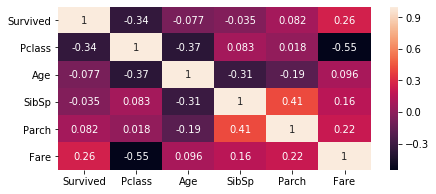

In [87]:
# 計算df整體相關係數, 並繪製成熱圖
import seaborn as sns
import matplotlib.pyplot as plt
corr = df.corr()
plt.figure(figsize=(7,3))
print(corr)
#sns.heatmap(corr)
sns.heatmap(df.corr(),annot=True)
plt.show()

In [88]:
# 記得刪除 SalePrice
df = df.drop(['Survived'] , axis=1)

#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1)
MMEncoder = MinMaxScaler()
df.head()

5 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']



,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


# 作業1
* 鐵達尼生存率預測中，試著變更兩種以上的相關係數門檻值，觀察預測能力是否提升?
> 由上述不同門檻可以發現, 相關係數有時候確實能成功提升準確度, 但篩選過頭會有反效果  
門檻的決定沒有一定的準則, 因此這個方法並不那麼好用

In [89]:
# 原始特徵 + 邏輯斯迴歸
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.neighbors import KNeighborsClassifier

train_X = MMEncoder.fit_transform(df)
estimator = LogisticRegression(solver='liblinear')

# 20
cross_val_score(estimator, train_X, train_Y, cv=5).mean()


#k_range = range(1,31)

#cv_scores = []

#for n in k_range:  
#    knn = KNeighborsClassifier(n)
#    scores = cross_val_score(knn,train_X,train_Y,cv=10,scoring='accuracy')
#    
#    cv_scores.append(scores.mean())
#    plt.plot(k_range,cv_scores) 


0.7038635542329971

In [90]:
# 篩選相關係數大於 0.05 或小於 -0.05 的特徵
high_list = list(corr[(corr['Survived']>0.05) | (corr['Survived']<-0.05)].index)
high_list.pop(0)
print(high_list)

['Pclass', 'Age', 'Parch', 'Fare']


In [91]:
# 0.05特徵 + 邏輯斯迴歸
train_X = MMEncoder.fit_transform(df[high_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.7049872206659582

In [92]:
# 篩選相關係數大於 0.1 或小於 -0.1 的特徵
high_list = list(corr[(corr['Survived']>0.1) | (corr['Survived']<-0.1)].index)
high_list.pop(0)
print(high_list)

['Pclass', 'Fare']


In [93]:
# 0.1特徵 + 邏輯斯迴歸
train_X = MMEncoder.fit_transform(df[high_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6791567235397566

In [94]:
# X_train, X_test, y_train, y_test = 
#train_test_split(train_data, train_target, test_size, random_state，shuffle)
#train_data：待劃分的樣本資料
#train_target：待劃分的對應樣本資料的樣本標籤
#test_size：1）浮點數，在0 ~ 1之間，表示樣本佔比（test_size = 0.3，則樣本資料中有30%的資料作為測試資料，記入X_test，其餘70%資料記入X_train，同時適用於樣本標籤）；2）整數，表示樣本資料中有多少資料記入X_test中，其餘資料記入X_train
#random_state：隨機數種子，種子不同，每次採的樣本不一樣；種子相同，採的樣本不變（random_state不取，取樣資料不同，但random_state等於某個值，取樣資料相同，取0的時候也相同，這可以自己程式設計嘗試下，不過想改變數值也可以設定random_state = int(time.time())）
#shuffle：洗牌模式，1）shuffle = False，不打亂樣本資料順序；2）shuffle = True，打亂樣本資料順
x=corr[['Pclass','Age','Fare']]
y=corr['Survived']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size = 0.33, random_state=42)
print(x_train)


         Pclass       Age      Fare
Fare  -0.549500  0.096067  1.000000
Age   -0.369226  1.000000  0.096067
Parch  0.018443 -0.189119  0.216225
SibSp  0.083081 -0.308247  0.159651


# 作業2
* 續上題，使用 L1 Embedding 做特徵選擇(自訂門檻)，觀察預測能力是否提升?
> 在作業與範例中, 效果並不如顯著  
而且與相關係數法類似, L1 Embedding 也需要調整 alpha 值, 且沒有一定法則  
所以也並非好用的特徵篩選方式

In [96]:
from sklearn.linear_model import Lasso
L1_Reg = Lasso(alpha=1)
train_X = MMEncoder.fit_transform(df)
L1_Reg.fit(train_X, train_Y)
L1_Reg.coef_

array([-0.,  0., -0.,  0.,  0.])

In [45]:
#•itertools 模块提供了很多用于产生多种类型迭代器的函数，它们的返回值不是 list，而是迭代器
from itertools import compress
L1_mask = list((L1_Reg.coef_>0) | (L1_Reg.coef_<0))
L1_list = list(compress(list(df), list(L1_mask)))
L1_list

['Pclass', 'Age', 'Parch']

In [46]:
# L1_Embedding 特徵 + 線性迴歸
train_X = MMEncoder.fit_transform(df[L1_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6993628951406613

In [37]:
# coef_=0 

L1_mask0 = list((L1_Reg.coef_==0) | (L1_Reg.coef_==0))
L1_list0 = list(compress(list(df), list(L1_mask0)))
L1_list0


['SibSp', 'Fare']